In [2]:
import gym
from stable_baselines3 import DQN
import open_clip
from PIL import Image
import torch
import numpy as np
from tensorboardX import SummaryWriter
import os
import scipy.stats as stats
import json
import matplotlib.pyplot as plt

import utils

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device is ", device)

In [4]:
utils.disable_view_window()

In [3]:
class CLIPEnv(object):
    def __init__(self, env, clip_model: open_clip.model.CLIP, clip_preprocess, tokenizer, prompts, writer, prompt_ensemble_strategy="max"):
        self.env = env

        self.model = clip_model
        self.preprocess = clip_preprocess
        self.tokenizer = tokenizer

        self.text_features = self.model.encode_text(self.tokenizer(prompts).to(device))
        self.text_features /= self.text_features.norm(dim=-1, keepdim=True)

        self.action_space = self.env.action_space
        self.observation_space = self.env.observation_space
        self.metadata = self.env.metadata

        self.prompts_ensemble_strategy = prompt_ensemble_strategy

        self.clip_rewards_per_episode = []
        self.env_rewards_per_episode = []

        self.clip_rewards = []
        self.env_rewards = []

        self.writer = writer
        self.n_steps = 0
        self.n_episodes = 0

    def reset(self):
        return self.env.reset()

    def close(self):
        return self.env.close()

    def step(self, action):
        next_st, rwd, done, info = self.env.step(action)
        img = self.env.render(mode="rgb_array")
        clip_rwd = self.get_clip_reward(img)

        self.env_rewards_per_episode.append(rwd)
        self.clip_rewards_per_episode.append(clip_rwd)

        if done:
            self.writer.add_scalar('episode_rewards/env_reward',  sum(self.env_rewards_per_episode), self.n_episodes)
            self.writer.add_scalar('episode_rewards/clip_reward', sum(self.clip_rewards_per_episode) , self.n_episodes)

            self.env_rewards.append(self.env_rewards_per_episode)
            self.clip_rewards.append(self.clip_rewards_per_episode)

            self.env_rewards_per_episode = []
            self.clip_rewards_per_episode = []

            self.n_episodes += 1

        self.n_steps += 1

        return next_st, rwd, done, info

    def get_clip_reward(self, state):
        with torch.no_grad(), torch.cuda.amp.autocast():
            image = self.preprocess(Image.fromarray(np.uint8(state)))
            image_features = self.model.encode_image(image.unsqueeze(0).to(device))
            image_features /= image_features.norm(dim=-1, keepdim=True)
            sim = (image_features @ self.text_features.T)
        sim = sim.cpu().detach().numpy()
        if self.prompts_ensemble_strategy == "max":
            return np.amax(sim[0])
        elif self.prompts_ensemble_strategy == "sum":
            return np.sum(sim[0])
        else:  # mean
            return np.mean(sim[0])

    @property
    def unwrapped(self):
        return self.env.unwrapped

In [7]:
!mkdir experiments

mkdir: cannot create directory ‘experiments’: File exists


In [5]:
def run_exp(agent, env, prompts, clip_model_name, env_name, exp_path, n_steps, notes=''):
    if not os.path.exists(exp_path):
        os.mkdir(exp_path)


    agent.learn(total_timesteps=n_steps, progress_bar=True)
    agent.save(f"{exp_path}/agent")

    corr = stats.pearsonr([sum(e) for e in env.env_rewards], [sum(e) for e in env.clip_rewards])[0]
    m_rwd = np.mean([sum(e) for e in env.env_rewards[-10:]])
    results = {
        'env_name': env_name,
        'prompt': prompts,
        'clip_model_name': clip_model_name,
        'correlation': corr,
        'mean_env_rwd_over_last_10_episodes': m_rwd,
        'n_episodes': env.n_episodes,
        'n_steps': env.n_steps,
         'notes': notes,
    }
    with open(f'{exp_path}/results.json', 'w') as f:
        json.dump(results, f)

    # compute correlation between env and clip rewards for each episode separately
    per_episode_corr = [stats.pearsonr(e, c)[0] for e, c in zip(env.env_rewards, env.clip_rewards)]
    for i in range(env.n_episodes):
        env.writer.add_scalar('Per episode correlation', per_episode_corr[i], i)

In [6]:
# Load CLIP
clip_model, _, clip_preprocess = open_clip.create_model_and_transforms('ViT-B-32-quickgelu', pretrained='laion400m_e32')
clip_tokenizer = open_clip.get_tokenizer('ViT-B-32-quickgelu')
clip_model.to(device)

In [ ]:
# Launch TensorBoard in Google Colab
%load_ext tensorboard
#%reload_ext tensorboard
%tensorboard --logdir /content/experiments/first_run/

In [ ]:
# OR alternatively launch TensorBoard on your local machine
!tensorboard --logdir 'experiments/first_run/' --host 0.0.0.0 --port 6006

In [7]:
EXP_PATH = 'experiments/first_run/'
ENV_NAME = 'LunarLander-v2'
N_STEPS = 20000

env = gym.make(ENV_NAME)
prompts = ['Spaceship is on the landing pad', 'The purple box is between two yellow triangles and is touching the white surface.']
writer = SummaryWriter(EXP_PATH)

cl_env = CLIPEnv(env, clip_model, clip_preprocess, clip_tokenizer, prompts, writer)

agent = DQN('MlpPolicy', cl_env, verbose=0, learning_starts=1000, buffer_size=15000, target_update_interval=500)
run_exp(agent, cl_env, prompts, 'open_clip_ViT-B-32-quickgelu', ENV_NAME, EXP_PATH, N_STEPS,
        'all additional info about experiment goes here')

Output()

C:\Users\IronTony\miniconda3\envs\ani\lib\site-packages\pyglet\image\codecs\wic.py:406: UserWarning: [WinError 
-2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))
   0% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/20,000  [ 0:00:00 < -:--:-- , ? it/s ]

C:\Users\IronTony\miniconda3\envs\ani\lib\site-packages\torch\amp\autocast_mode.py:202: UserWarning: User provided 
device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
   0% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/20,000  [ 0:00:00 < -:--:-- , ? it/s ]

KeyboardInterrupt: 

# Evaluate the trained agent

In [24]:
def experiment_prompt(prompt, agent, env, rewards_storage, n_steps=100):
    obs = env.reset()
    for _ in range(n_steps):
        action, _states = agent.predict(obs)
        obs, rewards, dones, info = env.step(action)
    rewards_storage[prompt] = (env.env_rewards.copy(), env.clip_rewards.copy())

In [25]:
prompt_rewards = {}

In [26]:
EXP_PATH = 'experiments/first_run/'
env = gym.make('LunarLander-v2')
cl_env = CLIPEnv(env, clip_model, clip_preprocess, clip_tokenizer, prompts, writer)
prompt = 'Spaceship is on the landing pad'

agent = DQN.load(f"{EXP_PATH}/agent", env=cl_env)
experiment_prompt(prompt, agent, cl_env, prompt_rewards)

In [18]:
cl_env.close()

Text(0.5, 1.0, 'Env rewards (1 episode)')

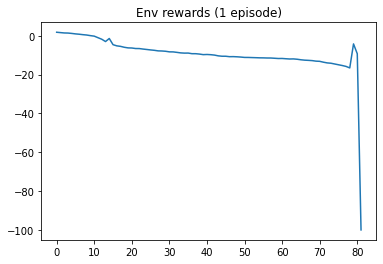

In [27]:
plt.plot(prompt_rewards[prompt][0][0])
plt.title('Env rewards (1 episode)')
plt.show()

Text(0.5, 1.0, 'CLIP rewards (1 episode)')

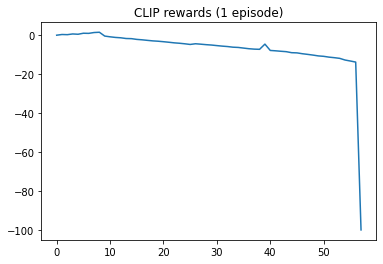

In [23]:
plt.plot(prompt_rewards[prompt][1][0])
plt.title('CLIP rewards (1 episode)')
plt.show()